# Clustering patients by longevity and disease scores
#### requires Disease_Longevity_UKBB notebook to be preprocessed (for model scores)

In [1]:
source(here::here("code/init.R"))
source(here::here("code/models.R"))
source(here::here("code/ukbb_outcome.R"))
source(here::here("code/ukbb_preprocessing.R"))
library(circlize)

circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




### Load scores

In [2]:
pop <- tgutil::fread(here::here('output/pop_scores.csv')) #see Disease_Longevity_UKBB notebook for computation
head(pop)

,id,age,sex,longevity,longevity_q,diabetes,ckd,copd,cvd,liver
,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1000054,45,female,0.9675882,0.1925792,0.08815524,0.04167553,0.02798628,0.2060382,0.022592036
2,1000112,45,male,0.9119281,0.1060348,0.15909692,0.03919249,0.09064247,0.2944900,0.008487539
3,1000186,45,female,0.9969831,0.4574361,0.20979514,0.13855365,0.12811647,0.6370679,0.022256322
4,1000198,45,male,0.9945255,0.3984270,0.07791844,0.05965531,0.04335517,0.2117718,0.033393441
5,1000255,45,female,0.9838166,0.2651281,0.08008288,0.02218681,0.06593383,0.1207745,0.009952694
6,1000379,45,male,0.9377217,0.1345166,0.03196407,0.04930571,0.01263509,0.1157229,0.014305011


### Computing probability for survival (to age 85) for all patients at age 50 using markovian lifelong risk models (precomputed on CHSDB)

In [3]:
raw_data_50 <- compute_lifelong_longevity_risk(
    pop %>% filter(age == 50, !is.na(longevity_q)) %>% distinct(id, .keep_all=TRUE)
)
head(raw_data_50 %>% select(-id))

,age,sex,longevity,longevity_q,diabetes,ckd,copd,cvd,liver,risk
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,50,female,0.9996638,0.66969314,0.9666981,0.8669417,0.64297649,0.9951463,0.63167019,0.5942129
2,50,female,0.9998648,0.74361493,0.9630811,0.7028427,0.16778195,0.9834435,0.41535100,0.6309899
3,50,female,0.9999993,0.96576855,0.9161818,0.7978059,0.93771530,0.9966076,0.75118800,0.8032003
4,50,female,0.9998899,0.75841987,0.8418077,0.5754285,0.37257428,0.9784567,0.16209624,0.6396717
5,50,female,0.9633808,0.16972589,0.8048885,0.2137487,0.03017582,0.8588606,0.19657983,0.4413530
6,50,female,0.8220811,0.04957433,0.0390171,0.1213760,0.01796421,0.1443699,0.01126879,0.3964383


##### loading precomputed models
Models were generated on CHSDB by clustering (kmeans) all scores of patients of age 50. UKBB scores are projected to these clusters. 

In [4]:
kmeans_centers_50 <- data.table::fread(here::here('data/models/age_50_clustering_centers.csv')) %>% 
    arrange(clust) %>% rename(longevity_q=q, cvd=ncvd)


In [5]:
colnames(kmeans_centers_50)
cluster_data_50 <- raw_data_50 %>% select(c('id', 'age', colnames(kmeans_centers_50 %>% select(-clust))))


[1] "longevity_q" "diabetes"    "ckd"         "copd"        "cvd"        
[6] "liver"       "clust"

##### divide work into jobs

In [6]:
#divide work into jobs
cluster_data_50 <- cluster_data_50 %>% 
    mutate(i=cut(1:n(), c(seq(1, n(), by=10000), n()), include.lowest=TRUE, right=FALSE))


In [7]:
message("working on ", length(unique(cluster_data_50$i)), " batches")
clusters_50 <- plyr::ddply(cluster_data_50, plyr::.(i), function(batch) {
    message(as.numeric(batch$i[1]))
    m <- as.matrix(kmeans_centers_50 %>% 
                   select(-clust) %>% 
                   bind_rows(batch %>% select(-id, -age, -i))
                  )
    mdist <- tgs_dist(m, tidy=TRUE)
    mdist_clust <- mdist %>% filter(row1 <= max(kmeans_centers_50$clust), 
                                    row2 > max(kmeans_centers_50$clust)) %>% 
            arrange(row2, dist) %>% 
        distinct(row2, .keep_all=TRUE) %>% 
        rename(clust=row1)
    return(batch %>% mutate(clust = mdist_clust$clust))
}) %>% select(-i) %>% 
    rename(longevity=longevity_q) %>% 
    reshape2::melt(id.vars=c("id", "age", "clust"))%>% 
    mutate(variable=factor(variable, levels=c('longevity', 'diabetes', 'ckd', 'copd', 'cvd', 'liver'))) %>% 
    mutate(clust=factor(paste0('C', clust), levels=paste0('C', 1:16)))


working on 7 batches

1

2

3

4

5

6

7



In [8]:

head(clusters_50 %>% select(-id))
    

,age,clust,variable,value
,<int>,<fct>,<fct>,<dbl>
1,50,C15,longevity,0.66969314
2,50,C13,longevity,0.74361493
3,50,C15,longevity,0.96576855
4,50,C13,longevity,0.75841987
5,50,C9,longevity,0.16972589
6,50,C1,longevity,0.04957433


##### compute average survival probability per cluster

In [9]:
risk <- clusters_50 %>% select(id, age, clust) %>% distinct %>% full_join(raw_data_50 %>% select(id, age, sex, risk)) %>%
    group_by(clust) %>% summarize(risk=round(mean(1-risk)*100))
risk

Joining with `by = join_by(id, age)`


clust,risk
<fct>,<dbl>
C1,51
C2,48
C3,42
C4,44
C5,46
C6,38
C7,31
C8,29
C9,42


##### compute average score per cluster

In [11]:
cmean <- clusters_50 %>% group_by(clust, variable) %>% 
        summarize(mean_value=mean(value, na.rm=T), .groups="drop")
head(cmean)

clust,variable,mean_value
<fct>,<fct>,<dbl>
C1,longevity,0.14745159
C1,diabetes,0.08932806
C1,ckd,0.06456448
C1,copd,0.03653607
C1,cvd,0.16699662
C1,liver,0.02177502


In [12]:
#this is used for cluster annotation
examples <- nrow(cluster_data_50)
cmtab <- clusters_50 %>% distinct(id, clust) %>% count(clust) %>% 
        left_join(cmean %>% pivot_wider(names_from=variable, values_from=mean_value), by="clust") %>% 
        mutate(p=n/sum(n)*100, title=paste0(ifelse(n>10000, paste0(round(n/1000), 'k'), n), '\n(', round(p), '%)')) %>% 
        bind_rows(data.frame(clust='C16', n=examples/0.92*0.08)) %>% #adding a fictitious spacer cluster
        mutate(clust=factor(clust,levels=paste0('C', 1:16))) %>% 
        arrange(clust)

In [13]:
head(cmtab)

,clust,n,longevity,diabetes,ckd,copd,cvd,liver,p,title
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,C1,13498,0.1474516,0.08932806,0.06456448,0.03653607,0.1669966,0.02177502,21.029180,13k (21%)
2,C2,11755,0.2165967,0.36880864,0.14949044,0.05729691,0.5818330,0.06202508,18.313677,12k (18%)
3,C3,4505,0.4868822,0.09851843,0.09516526,0.11372989,0.2512615,0.02947602,7.018555,4505 (7%)
4,C4,1651,0.3455071,0.37513925,0.49770368,0.14454156,0.7999694,0.10791873,2.572172,1651 (3%)
5,C5,96,0.3676718,0.26265214,0.21661124,0.16990092,0.5937081,0.63017959,0.149563,96 (0%)
6,C6,4922,0.5531317,0.34191303,0.23465462,0.17172258,0.7747784,0.08949527,7.668219,4922 (8%)


### Drawing the circular plot of clusters

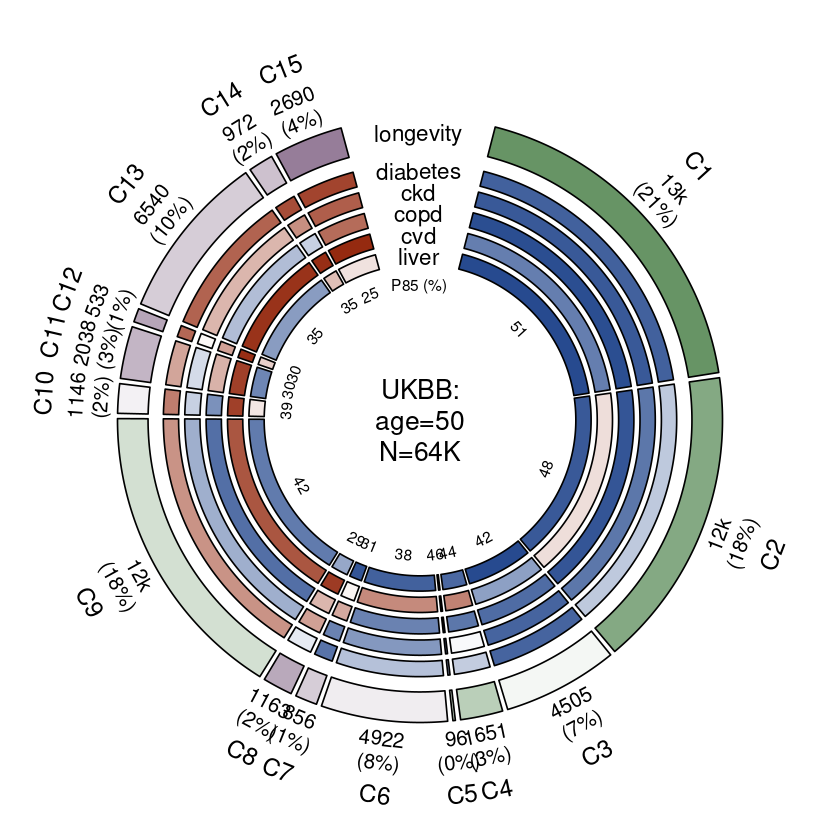

In [14]:
circ_longevity_pal <- colorRampPalette(c("#316f2f", "white", "#603a64"))(100)
circ_disease_pal <- colorRampPalette(c("#23478D", "white", "#93260C"))(100)

options(warn=-1)
circos.par(points.overflow.warning=FALSE)
#initialize circular plot
circos.par(cell.padding=c(0,0,0,0), start.degree=90-0.08*360/2, canvas.xlim=c(-1.2, 1.2), canvas.ylim=c(-1.2, 1.2))
circos.initialize(cmtab$clust, xlim=as.matrix(cmtab %>%  mutate(m=1) %>% select(m, n)))

#longevity score ring
circos.track(cmean$clust, ylim=c(0,1), track.height=0.1, track.margin=c(0.05, 0.01), 
    bg.col= colorRampPalette(circ_longevity_pal)(100)[floor(cmtab[,levels(cmean$variable)[1]]*100)],
    bg.border=c(rep("black", nrow(cmtab)-1), 'NA'), 
    panel.fun=function(x,y) {
        if (CELL_META$sector.index != "C16") {
            circos.text(CELL_META$xcenter, CELL_META$cell.ylim[2] + mm_y(15), CELL_META$sector.index, cex=1.2, niceFacing=TRUE)
            circos.text(CELL_META$xcenter, CELL_META$cell.ylim[2] + mm_y(6), cmtab %>% filter(clust == CELL_META$sector.index) %>% pull(title), cex=1, niceFacing=TRUE)
       }
    }
)

#disease score rings
purrr::walk2(levels(cmean$variable)[-1], 2:length(levels(cmean$variable)), function(var, ti) {
    circos.track(cmean$clust, ylim=c(0,1), track.height=0.05, track.margin=c(0.02, 0),
        bg.col= colorRampPalette(circ_disease_pal)(100)[floor(cmtab[,var]*100)],
        bg.border=c(rep("black", nrow(cmtab)-1), 'NA'))
})

#text ring
circos.track(cmean$clust, ylim=c(0,1), track.height=0.05, track.margin=c(0.02,0), 
    bg.col= rep('NA', nrow(cmtab)),
    bg.border=rep('NA', nrow(cmtab)),
    panel.fun=function(x,y) {
        if (CELL_META$sector.index != tail(levels(cmean$clust), 1)) { #dont want to print the spacer
                circos.text(CELL_META$xcenter, CELL_META$cell.ylim[2]-mm_y(3), 
                    risk %>% filter(clust == CELL_META$sector.index) %>% mutate(risk=paste0(risk, "")) %>% pull(risk), cex=0.75, niceFacing=TRUE)
        } else {
              circos.text(CELL_META$xcenter, CELL_META$cell.ylim[2]-mm_y(3), "P85 (%)", cex=0.75, niceFacing=TRUE)
        }

})

purrr::walk(1:length(levels(cmean$variable)), ~ circos.update('C16', .x, bg.border=NA))
    circos.text(x=get.cell.meta.data("xcenter", sector.index="C16"), y=0.5, labels='longevity', sector.index="C16", track.index=1, cex=1.1)
    purrr::walk2(levels(cmean$variable)[-1], 2:length(levels(cmean$variable)), ~
        circos.text(x=get.cell.meta.data("xcenter", sector.index="C16"), y=0.5, labels=.x, sector.index="C16", track.index=.y, cex=1.1))

text(0,0, paste0('UKBB', ':\nage=50\nN=', round(examples/1000), 'K'), cex=1.3)
options(warn=0)

In [17]:
child_clusters <- clusters_50 %>% distinct(id, clust) %>% mutate(clust=as.numeric(gsub('C', '', clust))) %>% 
            filter(clust==1 | clust == 3 | clust >= 10) %>% 
            mutate(clust=ifelse( clust >= 10 & clust < 15, '10-14', clust)) %>% 
            mutate(clust = factor(clust, levels=c('1', '3', '10-14', '15')))

### child survival by cluster

In [19]:
ukbb_demog <- data.table::fread(here::here('output/ukbb_demog.csv'))

clust_survival_data <- pop %>% filter(age == 50) %>% 
    inner_join(child_clusters, by="id") %>% 
        left_join(get_patients_survival(pop,ukbb_demog)) %>% mutate(follow_time=follow_time/365)
    
fit <- survminer::surv_fit(survival::Surv(follow_time, dead)~clust+sex, data=clust_survival_data)
stats <- survminer::surv_summary(fit, clust_survival_data)
clust_survival_10y <- stats %>% mutate(t=floor(time)) %>% 
        distinct(t, strata, .keep_all=T) %>% 
        filter(t == 10) %>% 
        mutate(cluster = factor(paste0("C", clust), levels=paste0('C', unique(clust))), sex=factor(sex, levels=c('male', 'female')))


Joining with `by = join_by(id, age, sex)`


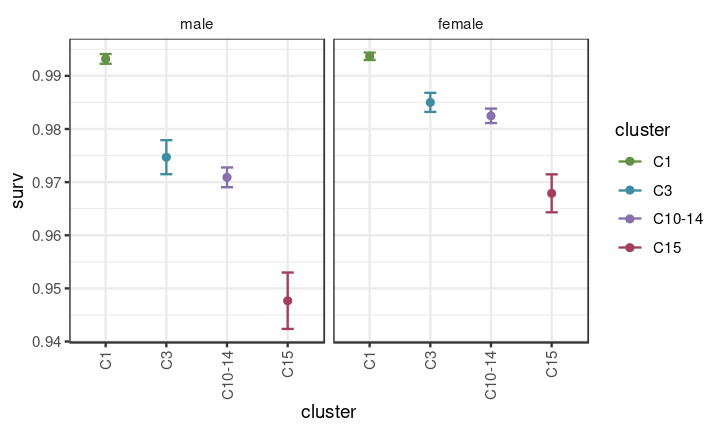

In [38]:
options(repr.plot.width=6, repr.plot.height=3.6)
g <- ggplot(clust_survival_10y, aes(x=cluster, y=surv, ymax=upper, ymin=lower, color=cluster)) + 
        geom_errorbar(width=0.2) + geom_point() + theme_bw() + ylab("surv") + 
        facet_wrap(~sex) + 
        scale_colour_manual(values=c('#649146', '#408da1',  '#8870ad', '#A1405D' )) + 
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), strip.background=element_blank())
g

In [39]:
#tgppt::plot_gg_ppt(g, out_ppt=here('figures/child_survival_by_child_clusters.pptx'), 
#    rasterize_plot=FALSE, top=11, left=9.2, width=9, height=6, overwrite=TRUE)

ERROR: Error in dyn.load(file, DLLpath = DLLpath, ...): unable to load shared object '/home/nettam/r_packs/openssl/libs/openssl.so':
  libssl.so.1.0.0: cannot open shared object file: No such file or directory


In [ ]:
### parent survival by cluster

In [20]:
parents <- data.table::fread(here::here('output/ukbb_parents.csv'))


In [21]:
cluster_parents <- child_clusters %>% left_join(parents, by="id") %>% left_join(pop %>% select(id, sex) %>% distinct, by="id") %>% rename(child=clust)
d <-  cluster_parents %>% 
     select(id, sex, parent_follow_time=mfollow_time, parent_dead=mdead, child) %>% 
        mutate(parent="mother") %>% 
        bind_rows(
            cluster_parents %>% 
            select(id, sex, parent_follow_time=ffollow_time, parent_dead=fdead, child) %>% 
            mutate(parent="father")
        ) %>% 
        filter(parent_follow_time > 0, !is.infinite(parent_follow_time))
    #fitting parent survival model by child clusters
    fparent <- survminer::surv_fit(survival::Surv(parent_follow_time, parent_dead) ~ child, data=d)
    age85 <- survminer::surv_summary(fparent, d) %>% filter(time == 85) %>% 
        mutate(cluster=gsub("child=", "", strata)) %>% 
        mutate(cluster = factor(cluster, levels=unique(cluster)))
    median_survival <- survminer::surv_median(fparent) %>% 
        mutate(cluster=gsub("child=", "", strata)) %>% 
        mutate(cluster = factor(cluster, levels=unique(cluster)))
    pvals <- survminer::pairwise_survdiff(survival::Surv(parent_follow_time, parent_dead) ~ child, data=d)
    
   gmedian <- ggplot(median_survival, aes(x=cluster, y=median, ymin=lower, ymax=upper, color=cluster)) + 
        geom_errorbar(width=0.2) + geom_point() + theme_bw() + ylab("median age of death") + 
        scale_colour_manual(values=c('#649146', '#408da1',  '#8870ad', '#A1405D' )) + 
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

Warning message:
"`select_()` was deprecated in dplyr 0.7.0.
i Please use `select()` instead.
i The deprecated feature was likely used in the survminer package.
  Please report the issue at <https://github.com/kassambara/survminer/issues>."



	Pairwise comparisons using Log-Rank test 

data:  d and child 

      1       3       10-14  
3     6.2e-08 -       -      
10-14 < 2e-16 < 2e-16 -      
15    < 2e-16 < 2e-16 2.1e-05

P value adjustment method: BH 

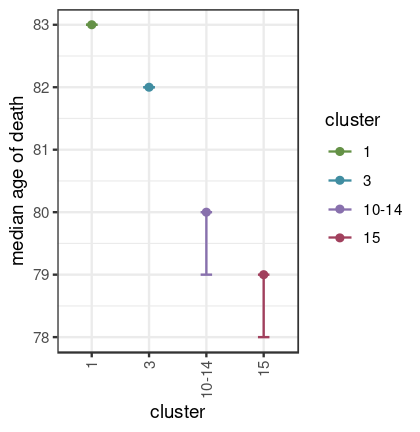

In [22]:
options(repr.plot.width=3.5, repr.plot.height=3.6)
pvals
gmedian


In [32]:
#tgppt::plot_gg_ppt(gmedian, out_ppt=here('figures/parents_survival_by_child_clusters.pptx'), 
#        rasterize_plot=FALSE, top=11, left=7, width=5, height=7, overwrite=TRUE, sep_legend=TRUE)